# Task 2.4 - Concentric sampled deformation gradients

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from keras import optimizers
from keras import losses

from src.models import CustomFFNN, CubicAnisoInvariantsICNN
from src.data_import import load_data
from src.plots import plot_loss
from src.utils import get_scores
from src.plot_and_predict import predict_and_plot_pann_model, predict_and_plot_naive_model

2024-12-10 15:38:58.784293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 15:38:58.787860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 15:38:58.799072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 15:38:58.816347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 15:38:58.820937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 15:38:58.834065: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
data_dir = os.path.abspath('task5_data')
train_paths = {
    'biaxial': os.path.join(data_dir, 'BCC_biaxial.txt'),
    'shear': os.path.join(data_dir, 'BCC_shear.txt'),
    'uniaxial': os.path.join(data_dir, 'BCC_uniaxial.txt'),
    'volumetric': os.path.join(data_dir, 'BCC_volumetric.txt')
}
test_paths = {
    'test1': os.path.join(data_dir, 'BCC_test1.txt'),
    'test2': os.path.join(data_dir, 'BCC_test2.txt'),
    'test3': os.path.join(data_dir, 'BCC_test3.txt')
}

## 2.5.1 - Data preperation

### Load Data

In [3]:
train_data = {
    key: load_data(path) for key, path in train_paths.items()
}
test_data = {
    key: load_data(path) for key, path in test_paths.items()
}

### Visualize

### Scaling

benefit -> nummerically stable

In [4]:
def scale_data(unscaled_data: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]], scale: float):
    scaled_data = {}
    for key, (F, P, _) in unscaled_data.items():
        P_scaled = P / scale
        scaled_data[key] = (F, P_scaled, _)
        print(f'Max P in {key}: {tf.reduce_max(P_scaled)}')
    return scaled_data

In [5]:
scale = 4_000.0
scaled_train_data = scale_data(train_data, scale)
scaled_test_data = scale_data(test_data, scale)

Max P in biaxial: 0.5641509890556335
Max P in shear: 0.3535967469215393
Max P in uniaxial: 0.5137190222740173
Max P in volumetric: 1.0698578357696533
Max P in test1: 0.6476467251777649
Max P in test2: 0.6702445149421692
Max P in test3: 0.48603224754333496


## 2.5.2 - Invariant based Model

/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


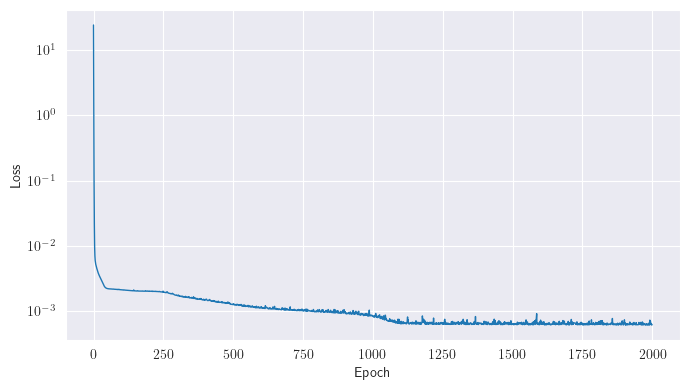

In [6]:
invariant_features = tf.concat([scaled_train_data['uniaxial'][0], scaled_train_data['shear'][0]], axis=0)
invariant_labels = tf.concat([scaled_train_data['uniaxial'][1], scaled_train_data['shear'][1]], axis=0)

invariant_model = CubicAnisoInvariantsICNN(
    hidden_sizes=[32, 32, 1],
    activations=['softplus', 'softplus', 'linear']
)
invariant_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
invariant_h = invariant_model.fit(invariant_features, invariant_labels, batch_size=32, epochs=2000, verbose=0)
invariant_loss = invariant_h.history['loss']
plot_loss(invariant_loss)

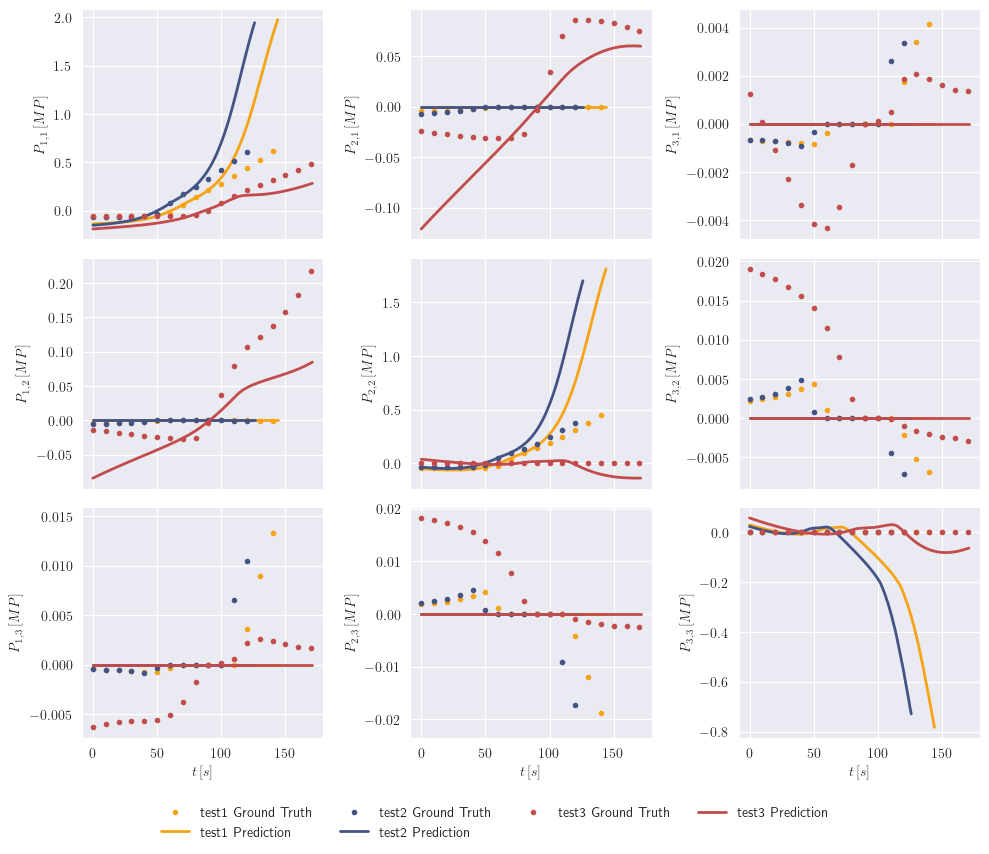

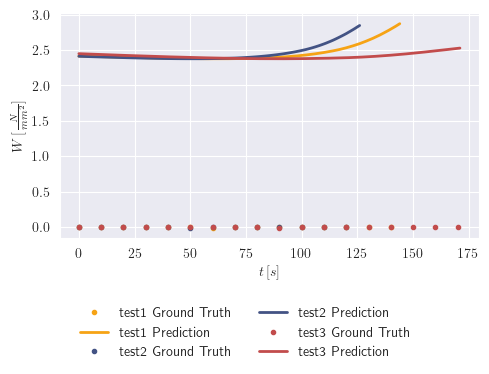

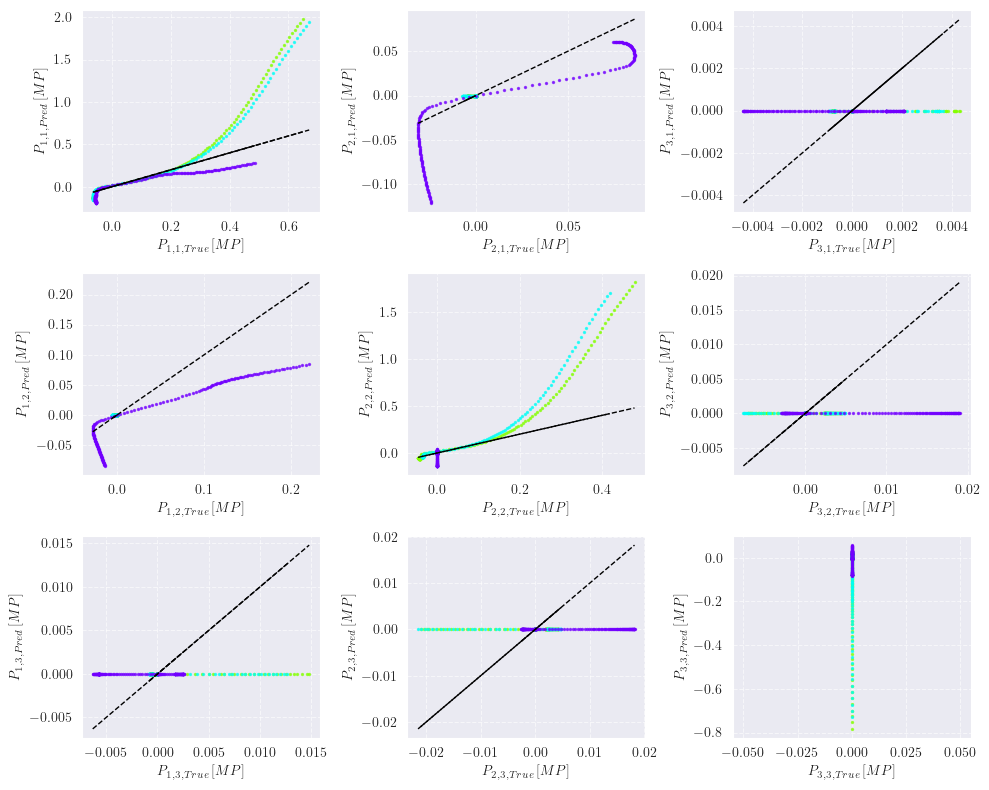

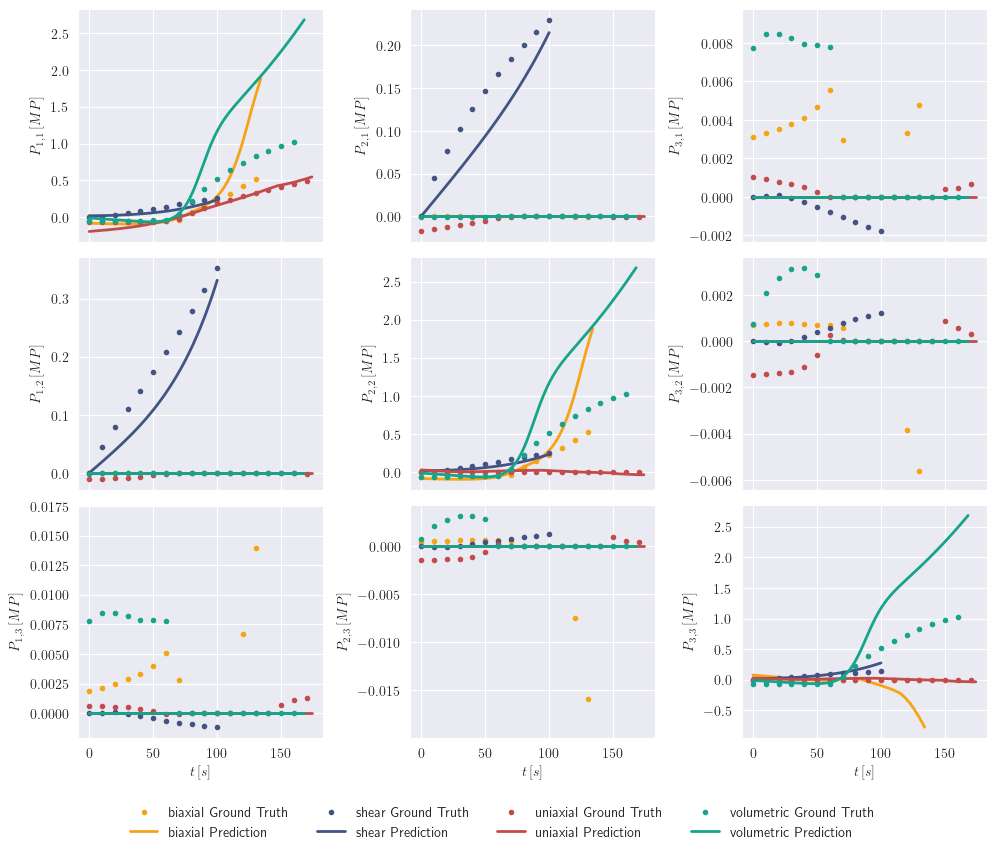

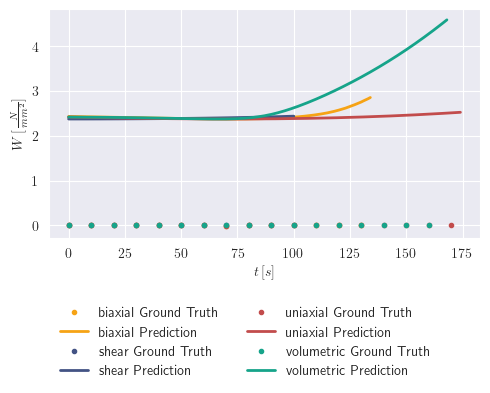

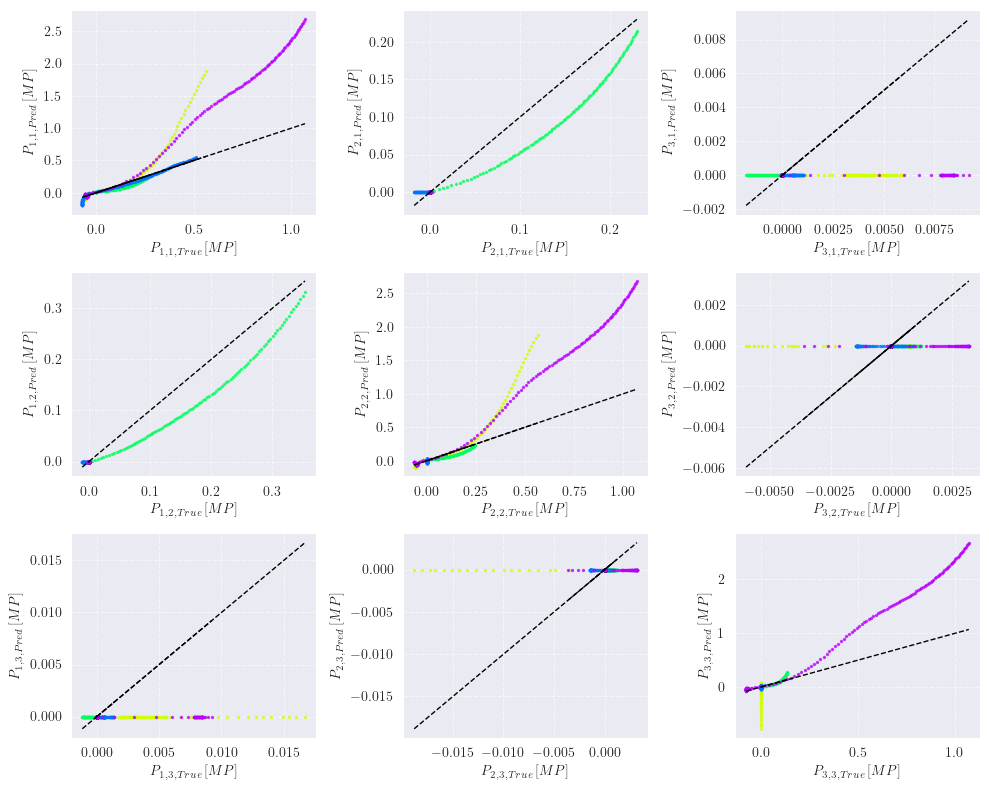

({'biaxial': array([[-5.8972549e-02,  2.4204111e-05,  1.9086890e-03, ...,
           3.1313552e-03,  6.8286003e-04,  0.0000000e+00],
         [-5.8898326e-02,  2.2769445e-05,  1.9327778e-03, ...,
           3.1450323e-03,  6.8924675e-04,  0.0000000e+00],
         [-5.8821097e-02,  2.1320555e-05,  1.9574668e-03, ...,
           3.1602001e-03,  6.9547677e-04,  0.0000000e+00],
         ...,
         [ 5.4300773e-01, -6.2039547e-04,  1.5403333e-02, ...,
           5.1288675e-03, -5.8727451e-03,  0.0000000e+00],
         [ 5.5371004e-01, -6.1177771e-04,  1.5946109e-02, ...,
           5.0062775e-03, -5.8420901e-03,  0.0000000e+00],
         [ 5.6404901e-01, -5.9797673e-04,  1.6702443e-02, ...,
           5.4407101e-03, -5.9672450e-03,  0.0000000e+00]], dtype=float32),
  'shear': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.98420006e-05,  4.782

In [ ]:
_ = predict_and_plot_pann_model(invariant_model, scaled_test_data)
_ = predict_and_plot_pann_model(invariant_model, scaled_train_data)

## 2.5.3 - Deformation-gradient based neural network model
just show that the model trained without roations is not able to fulfill observation

## 2.5.4 - Data augmentation
With rotations Q (different observers)